# Word Embedding

In this model, we will use neural network to classify the tweet sentiment.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import classification_report, cohen_kappa_score

import pickle

from timeit import default_timer as timer

from collections import Counter
from itertools import chain 

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical, plot_model

from custom_functions import clean_up, evaluating, scoring, get_pred

In [2]:
import gc

# remove unnecessary variables
def clean_up(vars_):
    for var in vars_:
        del var 
    print(gc.collect())

In [3]:
X_train = pd.read_pickle('PKL/X_train_fin.pkl')
X_val = pd.read_pickle('PKL/X_val_fin.pkl')
y_train = pd.read_csv('DATA/y_train.csv', index_col=0)
y_val = pd.read_csv('DATA/y_val.csv', index_col=0)

In [4]:
X_train = X_train['tweet']
X_val = X_val['tweet']

In [5]:
y_train = y_train['sentiment']
y_val = y_val['sentiment']

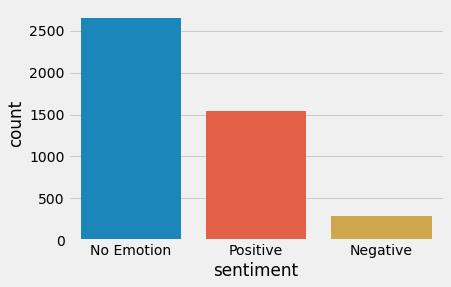

In [6]:
import seaborn as sns
plt.style.use('fivethirtyeight')
sns.countplot(y_train)
plt.xticks([0, 1, 2], ['No Emotion', 'Positive', 'Negative'])
plt.show()

In [7]:
y_train.value_counts()

No emotion toward brand or product    2651
Positive emotion                      1545
Negative emotion                       292
Name: sentiment, dtype: int64

## Input Setup
---
First, tokenize the words and pad them to be equal lengths.

In [8]:
num_vocab = 4000

In [9]:
tokenizer = Tokenizer(num_words = num_vocab)
tokenizer.fit_on_texts(X_train)

In [10]:
# convert to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

In [11]:
# add padding
X_train_seq = pad_sequences(X_train_seq)
X_val_seq = pad_sequences(X_val_seq, maxlen=len(X_train_seq[0]))

In [12]:
max_len = len(X_train_seq[0])

In [13]:
# Converting target to be a binary array
y_train_ohe = pd.get_dummies(y_train)
y_train = y_train_ohe.values
classes = list(y_train_ohe.columns)
y_val = pd.get_dummies(y_val).values

## LSTM
Without pretrained model, let's run simple LSTM.

In [41]:
model = Sequential()
model.add(Embedding(num_vocab, 200, input_length = max_len))
model.add(LSTM(200, dropout = 0.5))
model.add(Dense(100, activation = 'relu'))
model.add(Dense(3, activation = 'softmax'))

model.compile(optimizer = 'adam', 
             loss = 'categorical_crossentropy', 
             metrics = ['categorical_accuracy'])

In [42]:
cb = EarlyStopping(monitor = 'val_loss', mode = 'min', 
                   verbose = 1, patience = 5, restore_best_weights = True)

start = timer()
history = model.fit(X_train_seq, y_train,
                   epochs = 100, 
                   validation_data=(X_val_seq, y_val),
                   verbose = 2,  
                   callbacks = [cb], 
                   shuffle=True)

end = timer()
print('Total Time Elapsed:', end-start)

Epoch 1/100
141/141 - 17s - loss: 0.8526 - categorical_accuracy: 0.5878 - val_loss: 0.8447 - val_categorical_accuracy: 0.5820
Epoch 2/100
141/141 - 16s - loss: 0.7170 - categorical_accuracy: 0.6642 - val_loss: 0.8184 - val_categorical_accuracy: 0.6203
Epoch 3/100
141/141 - 16s - loss: 0.5374 - categorical_accuracy: 0.7758 - val_loss: 0.9046 - val_categorical_accuracy: 0.6230
Epoch 4/100
141/141 - 16s - loss: 0.4077 - categorical_accuracy: 0.8320 - val_loss: 1.0679 - val_categorical_accuracy: 0.6168
Epoch 5/100
141/141 - 16s - loss: 0.3313 - categorical_accuracy: 0.8688 - val_loss: 1.1752 - val_categorical_accuracy: 0.6105
Epoch 6/100
141/141 - 16s - loss: 0.2670 - categorical_accuracy: 0.8955 - val_loss: 1.3219 - val_categorical_accuracy: 0.6007
Epoch 7/100
Restoring model weights from the end of the best epoch.
141/141 - 15s - loss: 0.2377 - categorical_accuracy: 0.9055 - val_loss: 1.3746 - val_categorical_accuracy: 0.6078
Epoch 00007: early stopping
Total Time Elapsed: 114.9590237000

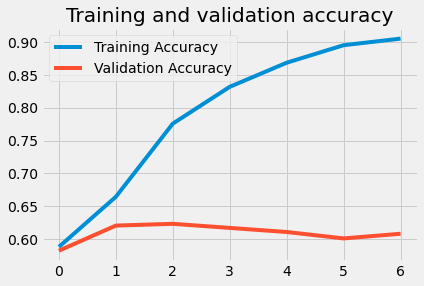

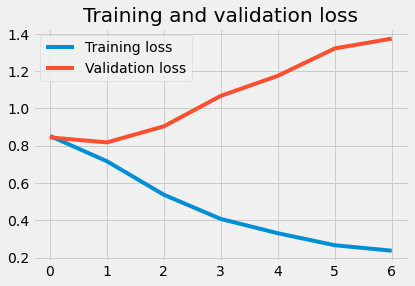

In [43]:
# plot performance
def plot_performance(hist):
    hist_ = hist.history
    epochs = hist.epoch

    plt.plot(epochs, hist_['categorical_accuracy'], label='Training Accuracy')
    plt.plot(epochs, hist_['val_categorical_accuracy'], label='Validation Accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    
    plt.figure()
    plt.plot(epochs, hist_['loss'], label='Training loss')
    plt.plot(epochs, hist_['val_loss'], label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
    plt.show()
    
plot_performance(history)

In [17]:
def change_to_classes(target):
    tmp = np.argmax(target, axis = 1)
    return np.where(tmp == 0, classes[0], 
        np.where(tmp == 1, classes[1], classes[2]))

def evaluate(model, X_val_seq, target):
    scores = model.evaluate(X_val_seq, target, verbose = 0)
    print('Loss:', round(scores[0], 4))
    print('Categorical Accuracy:', round(scores[1], 4))
    y_pred = model.predict(X_val_seq)
    y_val = change_to_classes(target)
    y_pred = change_to_classes(y_pred)
    print('Cohens Kappa', round(cohen_kappa_score(y_val, y_pred), 4))
    print(classification_report(y_val, y_pred))

In [44]:
evaluate(model, X_val_seq, y_val)

Loss: 0.8184
Categorical Accuracy: 0.6203
Cohens Kappa 0.2021
                                    precision    recall  f1-score   support

                  Negative emotion       0.36      0.05      0.09        77
No emotion toward brand or product       0.65      0.84      0.73       654
                  Positive emotion       0.55      0.36      0.44       391

                          accuracy                           0.62      1122
                         macro avg       0.52      0.42      0.42      1122
                      weighted avg       0.59      0.62      0.58      1122



## LSTM Iter 2 - GloVe Twitter 200d
Now let's use pretrained workd embedding with GloVe. 

### GloVe
GloVe embeddings have pretrained data on twitter. I'll use that in the model.

In [19]:
from gensim.models import word2vec

In [20]:
# building GloVe dictionary
#glove_path = '/Users/stereopickles/Documents/GloVe/glove.twitter.27B/glove.twitter.27B.200d.txt'
glove_path_pc = 'D:\Projects\GloVe_Twitter\glove.twitter.27B.200d.txt'
glove_dict = {}
with open(glove_path_pc, 'r', encoding = 'utf-8') as f:
    for line in f:
        vals = line.split(' ')
        glove_dict[vals[0]] = np.asarray(vals[1:], dtype = 'float32')

In [21]:
# save dictionary
#with open ('PKL/GloVe_dict.pkl', 'wb') as fp:
#    pickle.dump(glove_dict, fp)

In [22]:
with open('PKL/GloVe_dict.pkl', 'rb') as fp:
    glove_dict = pickle.load(fp)

In [23]:
# get embeddings for each word from the GloVe
word_emb_mat = np.zeros((num_vocab, 200))
for i in range(1, num_vocab):
    word = tokenizer.index_word[i]
    if word in glove_dict:
        word_emb_mat[i] = glove_dict[word]

In [45]:
model = Sequential()
model.add(Embedding(num_vocab, 200, weights = [word_emb_mat],
                    input_length = max_len))
model.add(LSTM(200, dropout = 0.5))
model.add(Dense(100, activation = 'relu'))
model.add(Dense(3, activation = 'softmax'))

model.compile(optimizer = 'adam', 
             loss = 'categorical_crossentropy', 
             metrics = ['categorical_accuracy'])

In [46]:
start = timer()
history = model.fit(X_train_seq, y_train,
                   epochs = 100, 
                   validation_data=(X_val_seq, y_val),
                   verbose = 2,  
                   callbacks = [cb], 
                   shuffle=True)

end = timer()
print('Total Time Elapsed:', end-start)

Epoch 1/100
141/141 - 16s - loss: 0.8297 - categorical_accuracy: 0.6083 - val_loss: 0.8053 - val_categorical_accuracy: 0.6328
Epoch 2/100
141/141 - 16s - loss: 0.7452 - categorical_accuracy: 0.6506 - val_loss: 0.7743 - val_categorical_accuracy: 0.6542
Epoch 3/100
141/141 - 15s - loss: 0.6725 - categorical_accuracy: 0.6936 - val_loss: 0.7972 - val_categorical_accuracy: 0.6194
Epoch 4/100
141/141 - 16s - loss: 0.6164 - categorical_accuracy: 0.7217 - val_loss: 0.8226 - val_categorical_accuracy: 0.6390
Epoch 5/100
141/141 - 15s - loss: 0.5529 - categorical_accuracy: 0.7516 - val_loss: 0.8665 - val_categorical_accuracy: 0.6515
Epoch 6/100
141/141 - 15s - loss: 0.4934 - categorical_accuracy: 0.7854 - val_loss: 0.9000 - val_categorical_accuracy: 0.6355
Epoch 7/100
Restoring model weights from the end of the best epoch.
141/141 - 15s - loss: 0.4435 - categorical_accuracy: 0.8084 - val_loss: 0.9702 - val_categorical_accuracy: 0.6203
Epoch 00007: early stopping
Total Time Elapsed: 111.8319415000

In [26]:
#model.save('MODEL/LSTM_v1.h5')

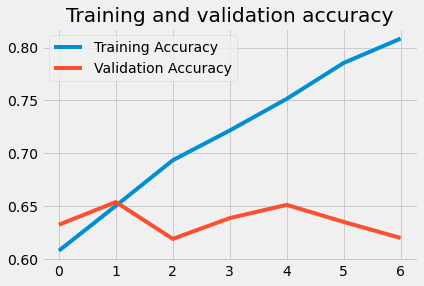

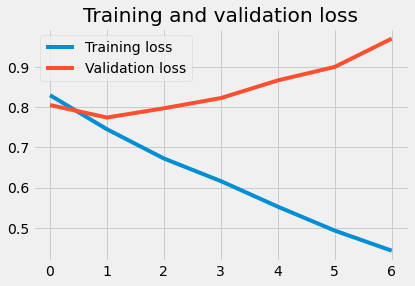

In [47]:
plot_performance(history)

In [48]:
evaluate(model, X_val_seq, y_val)

Loss: 0.7743
Categorical Accuracy: 0.6542
Cohens Kappa 0.2766
                                    precision    recall  f1-score   support

                  Negative emotion       0.62      0.06      0.12        77
No emotion toward brand or product       0.67      0.86      0.75       654
                  Positive emotion       0.61      0.43      0.51       391

                          accuracy                           0.65      1122
                         macro avg       0.64      0.45      0.46      1122
                      weighted avg       0.65      0.65      0.62      1122



Model is overall better but still not great. Let's try to add class weights.

## Iter 3 - Balanced Class Weight

### Calculating Weights

In [29]:
from sklearn.utils import class_weight

In [30]:
y = np.argmax(y_train, axis = 1)
cw = class_weight.compute_class_weight('balanced', np.unique(y), y)
cw = dict(zip(np.unique(y), cw))

D:\ProgramData\Anaconda3\envs\workspace-gpu\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1 2], y=[1 2 2 ... 1 1 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [49]:
model = Sequential()
model.add(Embedding(num_vocab, 200, weights = [word_emb_mat],
                    input_length = max_len))
model.add(LSTM(200, dropout = 0.5))
model.add(Dense(100, activation = 'relu'))
model.add(Dense(3, activation = 'softmax'))

model.compile(optimizer = 'adam', 
             loss = 'categorical_crossentropy', 
             metrics = ['categorical_accuracy'])

In [50]:
start = timer()
history = model.fit(X_train_seq, y_train,
                   epochs = 100, 
                   validation_data=(X_val_seq, y_val),
                   verbose = 2,  
                   callbacks = [cb], 
                    class_weight=cw,
                   shuffle=True)

end = timer()
print('Total Time Elapsed:', end-start)

Epoch 1/100
141/141 - 16s - loss: 1.0265 - categorical_accuracy: 0.4336 - val_loss: 0.9351 - val_categorical_accuracy: 0.5455
Epoch 2/100
141/141 - 15s - loss: 0.8829 - categorical_accuracy: 0.5412 - val_loss: 0.9281 - val_categorical_accuracy: 0.5205
Epoch 3/100
141/141 - 15s - loss: 0.7677 - categorical_accuracy: 0.5934 - val_loss: 0.8479 - val_categorical_accuracy: 0.5963
Epoch 4/100
141/141 - 14s - loss: 0.6623 - categorical_accuracy: 0.6515 - val_loss: 0.8974 - val_categorical_accuracy: 0.5446
Epoch 5/100
141/141 - 14s - loss: 0.6020 - categorical_accuracy: 0.6934 - val_loss: 0.8680 - val_categorical_accuracy: 0.5963
Epoch 6/100
141/141 - 14s - loss: 0.5170 - categorical_accuracy: 0.7219 - val_loss: 0.9774 - val_categorical_accuracy: 0.5526
Epoch 7/100
141/141 - 14s - loss: 0.4579 - categorical_accuracy: 0.7502 - val_loss: 0.9294 - val_categorical_accuracy: 0.6221
Epoch 8/100
Restoring model weights from the end of the best epoch.
141/141 - 14s - loss: 0.4221 - categorical_accurac

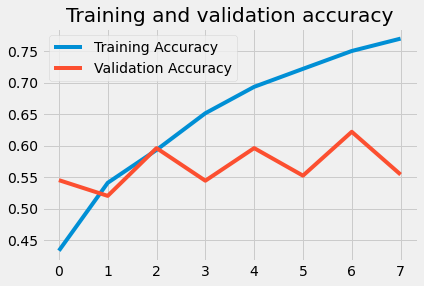

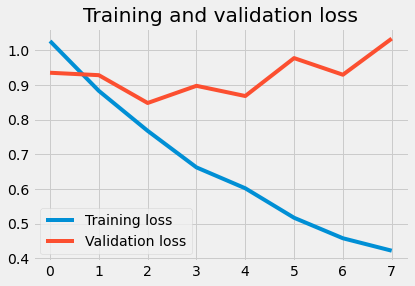

In [51]:
plot_performance(history)

In [52]:
evaluate(model, X_val_seq, y_val)

Loss: 0.8479
Categorical Accuracy: 0.5963
Cohens Kappa 0.2913
                                    precision    recall  f1-score   support

                  Negative emotion       0.20      0.40      0.27        77
No emotion toward brand or product       0.72      0.63      0.67       654
                  Positive emotion       0.57      0.58      0.57       391

                          accuracy                           0.60      1122
                         macro avg       0.50      0.54      0.51      1122
                      weighted avg       0.63      0.60      0.61      1122



It improved the recall score of negative emotion but at the sacrifice of its precision and overall accuracy.

## Iteration 4 - More Dropout
Let's try to add more dropout to make this more generalizable.

In [53]:
model = Sequential()
model.add(Embedding(num_vocab, 200, weights = [word_emb_mat],
                    input_length = max_len))
model.add(Dropout(0.5))
model.add(LSTM(200, dropout = 0.5))
model.add(Dense(100, activation = 'relu'))
model.add(Dense(3, activation = 'softmax'))

model.compile(optimizer = 'adam', 
             loss = 'categorical_crossentropy', 
             metrics = ['categorical_accuracy'])

In [54]:
start = timer()
history = model.fit(X_train_seq, y_train,
                   epochs = 100, 
                   validation_data=(X_val_seq, y_val),
                   verbose = 2,  
                   callbacks = [cb], 
                   shuffle=True)

end = timer()
print('Total Time Elapsed:', end-start)

Epoch 1/100
141/141 - 15s - loss: 0.8475 - categorical_accuracy: 0.5860 - val_loss: 0.8102 - val_categorical_accuracy: 0.6061
Epoch 2/100
141/141 - 14s - loss: 0.8009 - categorical_accuracy: 0.6161 - val_loss: 0.8437 - val_categorical_accuracy: 0.6123
Epoch 3/100
141/141 - 14s - loss: 0.7739 - categorical_accuracy: 0.6366 - val_loss: 0.8064 - val_categorical_accuracy: 0.6292
Epoch 4/100
141/141 - 15s - loss: 0.7400 - categorical_accuracy: 0.6562 - val_loss: 0.7994 - val_categorical_accuracy: 0.6408
Epoch 5/100
141/141 - 14s - loss: 0.7033 - categorical_accuracy: 0.6734 - val_loss: 0.7795 - val_categorical_accuracy: 0.6417
Epoch 6/100
141/141 - 15s - loss: 0.6766 - categorical_accuracy: 0.6887 - val_loss: 0.8101 - val_categorical_accuracy: 0.6480
Epoch 7/100
141/141 - 15s - loss: 0.6441 - categorical_accuracy: 0.7135 - val_loss: 0.8168 - val_categorical_accuracy: 0.6560
Epoch 8/100
141/141 - 14s - loss: 0.6165 - categorical_accuracy: 0.7206 - val_loss: 0.8233 - val_categorical_accuracy:

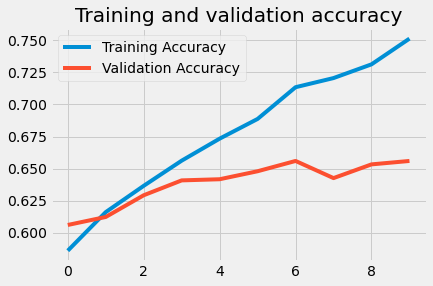

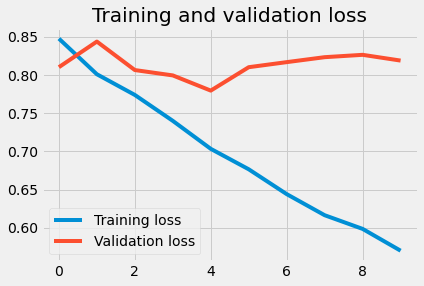

In [55]:
plot_performance(history)

In [56]:
evaluate(model, X_val_seq, y_val)

Loss: 0.7795
Categorical Accuracy: 0.6417
Cohens Kappa 0.2796
                                    precision    recall  f1-score   support

                  Negative emotion       0.60      0.04      0.07        77
No emotion toward brand or product       0.68      0.78      0.73       654
                  Positive emotion       0.56      0.54      0.55       391

                          accuracy                           0.64      1122
                         macro avg       0.61      0.45      0.45      1122
                      weighted avg       0.63      0.64      0.62      1122



## Iteration 5 - Increase Learning Rate
Out training loss graph shows that our learning rate is too low. Let's try to increase that.

In [61]:
from tensorflow.keras import optimizers

In [74]:
model = Sequential()
model.add(Embedding(num_vocab, 200, weights = [word_emb_mat],
                    input_length = max_len))
model.add(Dropout(0.5))
model.add(LSTM(200, dropout = 0.5))
model.add(Dense(100, activation = 'relu'))
model.add(Dense(3, activation = 'softmax'))

model.compile(optimizer = optimizers.Adam(learning_rate=0.01), 
             loss = 'categorical_crossentropy', 
             metrics = ['categorical_accuracy'])

In [75]:
start = timer()
history = model.fit(X_train_seq, y_train,
                   epochs = 100, 
                   validation_data=(X_val_seq, y_val),
                   verbose = 2,  
                   callbacks = [cb], 
                   shuffle=True)

end = timer()
print('Total Time Elapsed:', end-start)

Epoch 1/100
141/141 - 15s - loss: 0.8639 - categorical_accuracy: 0.5907 - val_loss: 0.8755 - val_categorical_accuracy: 0.5963
Epoch 2/100
141/141 - 14s - loss: 0.7691 - categorical_accuracy: 0.6406 - val_loss: 0.8583 - val_categorical_accuracy: 0.6497
Epoch 3/100
141/141 - 14s - loss: 0.6889 - categorical_accuracy: 0.7014 - val_loss: 0.9488 - val_categorical_accuracy: 0.6426
Epoch 4/100
141/141 - 14s - loss: 0.6248 - categorical_accuracy: 0.7342 - val_loss: 1.0213 - val_categorical_accuracy: 0.6471
Epoch 5/100
141/141 - 14s - loss: 0.5674 - categorical_accuracy: 0.7638 - val_loss: 0.8773 - val_categorical_accuracy: 0.6373
Epoch 6/100
141/141 - 14s - loss: 0.5269 - categorical_accuracy: 0.7861 - val_loss: 0.9466 - val_categorical_accuracy: 0.6426
Epoch 7/100
Restoring model weights from the end of the best epoch.
141/141 - 14s - loss: 0.4947 - categorical_accuracy: 0.8001 - val_loss: 1.1030 - val_categorical_accuracy: 0.6453
Epoch 00007: early stopping
Total Time Elapsed: 102.5315627000

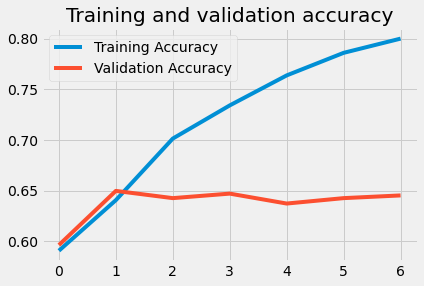

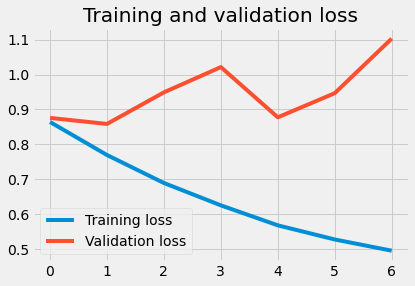

In [76]:
plot_performance(history)

In [77]:
evaluate(model, X_val_seq, y_val)

Loss: 0.8583
Categorical Accuracy: 0.6497
Cohens Kappa 0.2921
                                    precision    recall  f1-score   support

                  Negative emotion       0.40      0.03      0.05        77
No emotion toward brand or product       0.69      0.80      0.74       654
                  Positive emotion       0.57      0.53      0.55       391

                          accuracy                           0.65      1122
                         macro avg       0.55      0.45      0.45      1122
                      weighted avg       0.63      0.65      0.63      1122



In [65]:
evaluate(model, X_val_seq, y_val)

Loss: 0.803
Categorical Accuracy: 0.6462
Cohens Kappa 0.2814
                                    precision    recall  f1-score   support

                  Negative emotion       0.26      0.08      0.12        77
No emotion toward brand or product       0.68      0.82      0.74       654
                  Positive emotion       0.59      0.47      0.52       391

                          accuracy                           0.65      1122
                         macro avg       0.51      0.46      0.46      1122
                      weighted avg       0.62      0.65      0.62      1122

